# Text mining 
## Lab 08 Multi-Layer Perceptron on Reuters with reguarization techniques

We are going to train a Neural Network to predict the origin of a document coming from the 20newsgroup dataset.

For this puprose we'll use Tensorflow, and sklearn. Your job is to fill in the missing code into the cells below.

You will find the steps you need to perform in the **Task** section in each cell.

# Homework

## Tasks


0.   Load and preprocess the data for 20newsgroups
1.   Create a multi layer perceptron (MLP) with N hidden layers with ReLU activation, and an Softmax output layer.
2.   Compute it's gradients (manually or using tensorflow's API)
3.   Compile the model with 'categorical_crossentropy' loss, and add metric 'accuracy'
4.   Fill the dropout logic (it must be per layer)
5.   Fill the l2 regularization logic (it must be per layer)
6.   Fill the logic for early stopping
7.   Fix the plotting function plot_history()

## Submission

You must submit your code with experiments:
1. Different number of layers
2. Compare l2, droput and early stopping 
3. Learning curves for train and test metrics (acc, loss) per each experiment

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from nltk import TweetTokenizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import regularizers, initializers

In [2]:
def next_batch(x_, y_, batch_size, ids = None):
    if (ids is None):
        # Random sample from the dataset. It can be sequential (but must be shuffled) within epoch, that will guarantee that you'll use all the data.
        # The two approaches are practically equal when using a large number of epochs.
        ids = np.random.choice(x_.shape[0], batch_size, replace=False)


    feed_dict = {
      'x': x_[ids],
      'y': y_[ids]
    }

    return feed_dict

def tweet_tokenize(text):
    tknzr = TweetTokenizer(preserve_case=True, strip_handles=True)
    return tknzr.tokenize(text)
  
def evalute_accuracy(x, y):
    return sess.run(accuracy, feed_dict = next_batch(x, y, len(x)))

In [3]:
hparams = tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = False,
    use_early_stoppoing = True,
    early_stopping_patience = 3,
    use_l2_reg = False,
    layers = 2,
    seed = 42
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Data Loading 
We are going to use the 20newsgroup dataset for multi-class text classification with Tensorflow.

First we use the [fetch_20newgroup](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) module from sklearn. 

In [4]:
print('Loading data...')

# Passing none as we want to train over all the data.
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=None)

newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=None)

print('Data loaded.')

Loading data...
Data loaded.


# Preprocessing

In this paragraph you need to pre-process your data and create vectors suitable for feeding the NN. You can try different transorfmations and features, TFIDF would be a good start.

You can use:<

1.   [Tokenizer](https://keras.io/preprocessing/text/#tokenizer) from Keras, and to convert the list in newsgrops_\*.data into BOW (Bag-Of-Words) vectors.
2.   Convert the labels to OneHot encoded vectors e.g. for label '2' your vector should look like this [0, 0, ..., 1, 0] helpers can be found [here](https://keras.io/utils/);

## Expected output

20 classes

Vectorizing sequence data...

x_train shape: (11314, max_features)

x_test shape: (7532, max_features)

Convert class vector to binary class matrix (for use with categorical_crossentropy)

y_train shape: (11314, 20)

y_test shape: (7532, 20)

In [5]:
num_classes = np.max(newsgroups_train.target) + 1

print(num_classes, 'classes')

print('Vectorizing sequence data...')

tokenizer = Tokenizer(num_words=hparams.max_features)
tokenizer.fit_on_texts(newsgroups_train.data)

x_train = tokenizer.texts_to_matrix(newsgroups_train.data, mode='binary')
x_test = tokenizer.texts_to_matrix(newsgroups_test.data, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')

y_train = to_categorical(newsgroups_train.target, num_classes)
y_test = to_categorical(newsgroups_test.target, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

20 classes
Vectorizing sequence data...
x_train shape: (11314, 1000)
x_test shape: (7532, 1000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (11314, 20)
y_test shape: (7532, 20)


# Model building
For the architecture you can refer to the picture below. 

You can find detailed overview of backprop [here](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/).

You can find detailed overview of regularization [here](http://www.deeplearningbook.org/contents/regularization.html).


![alt text](http://paddlepaddle.org/docs/develop/book/02.recognize_digits/image/softmax_regression_en.png)

In [6]:
def create_model(hparams):
    input_layer = layers.Input(shape=(hparams.max_features,), name='input')
    hidden = input_layer

    for i in range(hparams.layers):
        #create layers
        hidden = layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=regularizers.l2(hparams.reg_param) if hparams.use_l2_reg else None,
            kernel_initializer=initializers.glorot_normal(seed=hparams.seed),
            name='dense-{}'.format(i)
        )(hidden)

        if hparams.use_dropout:
            #use hparams.dropout_keep_prob and add dropout mask
            hidden = layers.Dropout(rate=1 - hparams.dropout_keep_prob)(hidden)

    # Softmax over classes for ouput
    output_layer = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(hparams.reg_param) if hparams.use_l2_reg else None,
        kernel_initializer=initializers.glorot_normal(seed=hparams.seed),
        name='output'
    )(hidden)

    if hparams.use_dropout:
        #use hparams.dropout_keep_prob and add dropout mask
        output_layer = layers.Dropout(rate=1 - hparams.dropout_keep_prob)(output_layer)

    model = Model(inputs=[input_layer], outputs=output_layer)

    # Minimize error using cross entropy
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    model.summary()
    return model

model = create_model(hparams)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 20)                2580      
Total params: 147,220
Trainable params: 147,220
Non-trainable params: 0
_________________________________________________________________


# Model training

In this section you'll only need to run the cells, you don't have to modify them!

In [7]:
def train_model(model, hparams):
    full_history = {
        'loss': [[], []],
        'acc': [[], []]
    }

    patience = 0
    best_test_loss = np.inf
    best_epoch = 0

    # Training cycle
    for epoch in range(hparams.max_epochs):
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=hparams.batch_size,
            epochs=1,
            shuffle=True
        )

        train_loss = history.history['loss'][0]
        train_acc = history.history['acc'][0]

        test_loss, test_acc = model.evaluate(
            x=x_test,
            y=y_test,
            batch_size=hparams.batch_size
        )

        full_history['loss'][0].append(train_loss)
        full_history['loss'][1].append(test_loss)

        full_history['acc'][0].append(train_acc)
        full_history['acc'][1].append(test_acc)

        if hparams.use_early_stoppoing:
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_epoch = epoch
            else:
                if patience < hparams.early_stopping_patience:
                    patience = patience + 1
                else:
                    print('best epoch to stop is: {} with loss: {}'.format(best_epoch, best_test_loss))
                    break

    print("Optimization Finished!")
    return full_history

history = train_model(model, hparams)

Instructions for updating:
Use tf.cast instead.
7532/7532 [==============================] - 0s 25us/sample - loss: 1.5924 - acc: 0.6241
best epoch to stop is: 0 with loss: 1.1848081243335726
Optimization Finished!


In [8]:
def visualize_history(history, key='loss'):
    plt.plot(history[key][0])
    plt.plot(history[key][1])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt

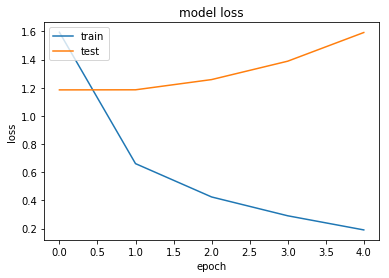

In [9]:
visualize_history(history, key='loss').show()

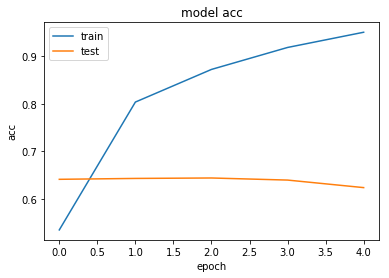

In [10]:
visualize_history(history, key='acc').show()

In [11]:
def run_experiment(hparams, title='Experiment'):
    print('RUNNING EXPERIMENT: {}'.format(title))
    model = create_model(hparams)
    history = train_model(model, hparams)
    visualize_history(history, key='loss').show()
    visualize_history(history, key='acc').show()
    final_test_loss = history['loss'][1][-1]
    final_test_acc = history['acc'][1][-1]
    print('Final test loss: {}'.format(final_test_loss))
    print('Final test accuracy: {}'.format(final_test_acc))

RUNNING EXPERIMENT: 1) 2 Layers, L2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 20)                2580      
Total params: 147,220
Trainable params: 147,220
Non-trainable params: 0
_________________________________________________________________
11314/11314 [==============================] - 1s 81us/sample - loss: 2.8284 - acc: 0.2496


7532/7532 [==============================] - 0s 28us/sample - loss: 2.8599 - acc: 0.2477


7532/7532 [==============================] - 0s 31us/sample - loss: 2.8602 - acc: 0.2493
Optimization Finished!


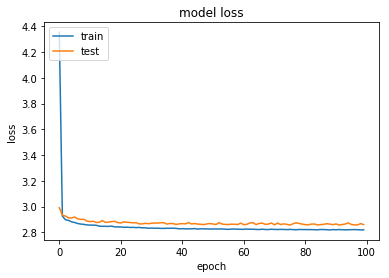

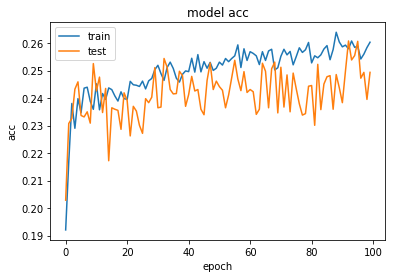

Final test loss: 2.860218814757677
Final test accuracy: 0.24933616816997528


In [12]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = False,
    use_early_stoppoing = False,
    early_stopping_patience = 1,
    use_l2_reg = True,
    layers = 2,
    seed = 42
), title="1) 2 Layers, L2")

RUNNING EXPERIMENT: 2) 2 Layers, Dropout
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 20)             

7532/7532 [==============================] - 0s 28us/sample - loss: nan - acc: 0.0424


7532/7532 [==============================] - 0s 32us/sample - loss: nan - acc: 0.0424
Optimization Finished!


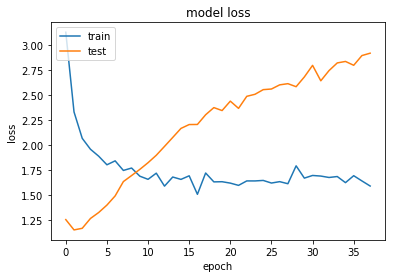

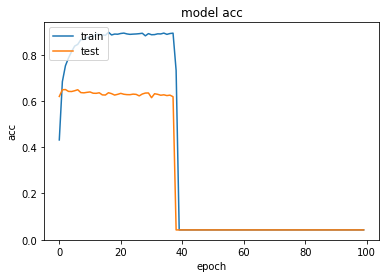

Final test loss: nan
Final test accuracy: 0.04235262796282768


In [13]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = True,
    use_early_stoppoing = False,
    early_stopping_patience = 1,
    use_l2_reg = False,
    layers = 2,
    seed = 42
), title="2) 2 Layers, Dropout")

RUNNING EXPERIMENT: 3) 2 Layers, Early Stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 20)                2580      
Total params: 147,220
Trainable params: 147,220
Non-trainable params: 0
_________________________________________________________________
7532/7532 [==============================] - 0s 29us/sample - loss: 1.7183 - acc: 0.6279
best epoch to stop is: 1 with loss: 1.1829048868701995
Optimization Finished!


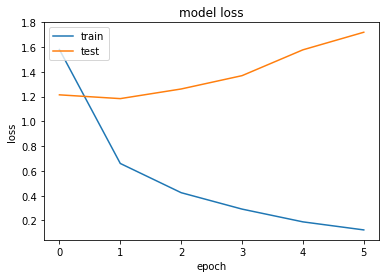

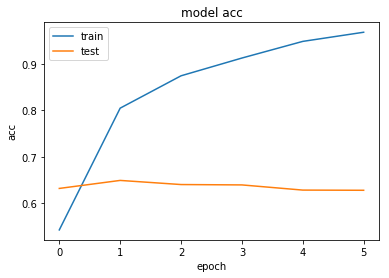

Final test loss: 1.7182685572988354
Final test accuracy: 0.6278544664382935


In [14]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = False,
    use_early_stoppoing = True,
    early_stopping_patience = 3,
    use_l2_reg = False,
    layers = 2,
    seed = 42
), title="3) 2 Layers, Early Stopping")

RUNNING EXPERIMENT: 4) 2 Layers, L2, Dropout
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 20)                2580      
_________________________________________________________________
dropout_5 (Dropout)          (N

11314/11314 [==============================] - 1s 87us/sample - loss: 4.2039 - acc: 0.1184


7532/7532 [==============================] - 0s 30us/sample - loss: 2.8817 - acc: 0.1251
Optimization Finished!


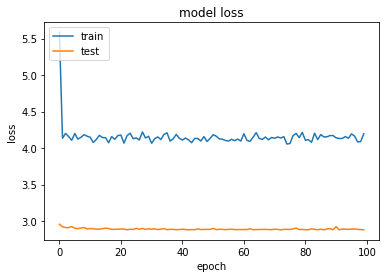

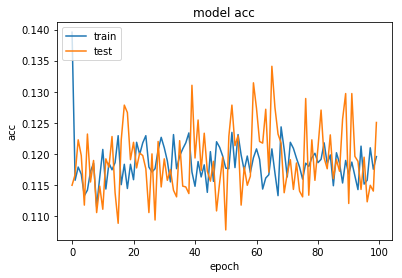

Final test loss: 2.881667776431926
Final test accuracy: 0.1250663846731186


In [15]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = True,
    use_early_stoppoing = False,
    early_stopping_patience = 3,
    use_l2_reg = True,
    layers = 2,
    seed = 42
), title="4) 2 Layers, L2, Dropout")

RUNNING EXPERIMENT: 5) 3 Layers, Dropout, Early Stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense-2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)

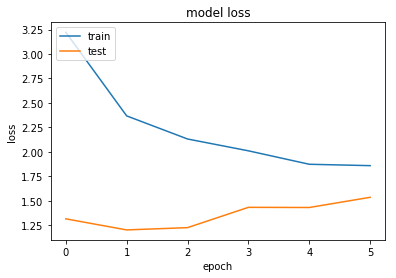

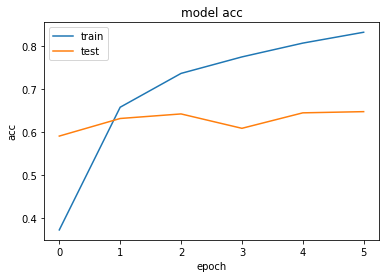

Final test loss: 1.5360263143520183
Final test accuracy: 0.6480350494384766


In [16]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = True,
    use_early_stoppoing = True,
    early_stopping_patience = 3,
    use_l2_reg = False,
    layers = 3,
    seed = 42
), title="5) 3 Layers, Dropout, Early Stopping")

RUNNING EXPERIMENT: 6) 3 Layers, L2, Early Stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense-2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 20)                2580      
Total params: 163,732
Trainable params: 163,732
Non-trainable params: 0
_________________________________________________________________
7532/7532 [==============================] - 0s 35us/sample - loss: 2.8889 - acc: 0.

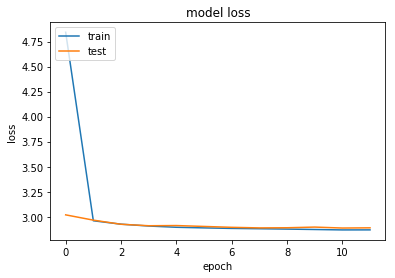

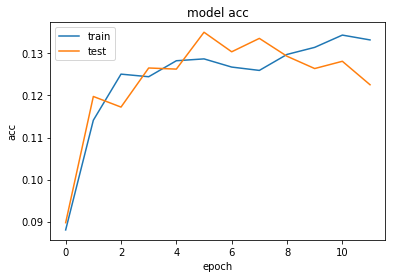

Final test loss: 2.8889461337285542
Final test accuracy: 0.1225438117980957


In [17]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = False,
    use_early_stoppoing = True,
    early_stopping_patience = 3,
    use_l2_reg = True,
    layers = 3,
    seed = 42
), title="6) 3 Layers, L2, Early Stopping")

RUNNING EXPERIMENT: 7) 3 Layers, L2, Dropout, Early Stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
dense-0 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense-1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense-2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_12 (Dro

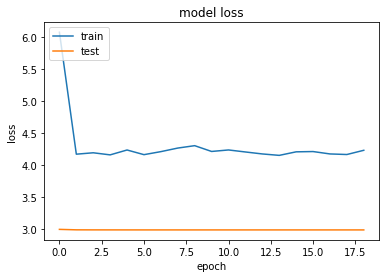

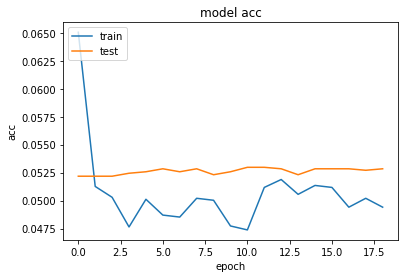

Final test loss: 2.9902841645988834
Final test accuracy: 0.05284121260046959


In [18]:
run_experiment(tf.contrib.training.HParams(
    batch_size = 32,
    max_epochs = 100,
    max_features = 1000,
    learning_rate = 0.03,
    reg_param = 0.03,
    dropout_keep_prob = 0.9,
    use_dropout = True,
    use_early_stoppoing = True,
    early_stopping_patience = 3,
    use_l2_reg = True,
    layers = 3,
    seed = 42
), title="7) 3 Layers, L2, Dropout, Early Stopping")